In [49]:
%pylab
%matplotlib inline 
from scipy.fftpack import fft, ifft, fftshift, fftfreq

Using matplotlib backend: TkAgg
Populating the interactive namespace from numpy and matplotlib


/home/mike/.conda/envs/idp/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['fft', 'axes', 'ifft']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


Let's check out the FFTs for C+A cos(ft + phi) and A exp(- B (t- L/2)^2)

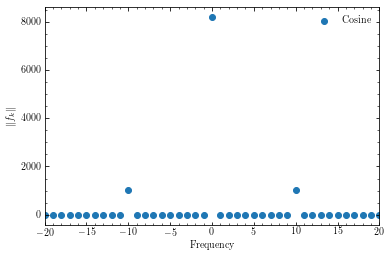

In [2]:
N = 4096
L = 1.
t = np.linspace(0,1,N)
freqs = fftfreq(N) * N / L
f1 = 2. + 0.5 * np.cos(2*np.pi * 10 * t + np.pi/4) # cosine function
fft1 = fft(f1)
plt.scatter(freqs, np.abs(fft1), label="Cosine")
plt.xlim(-20, 20)
plt.xlabel("Frequency")
plt.ylabel(r"$\|f_k\|$")
plt.legend()
plt.savefig("cosine_fft.pdf", bbox_inches='tight')


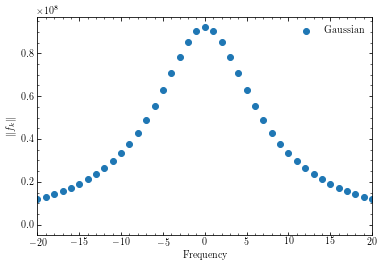

In [3]:
plt.clf()
f2 = 0.5 / (2*np.pi*0.1**2)**0.5 * np.exp((t - L/2)**2 / 2 / (0.1**2)) # cosine function
fft2 = fft(f2)

plt.scatter(freqs, np.abs(fft2), label='Gaussian')
plt.xlim(-20, 20)
plt.xlabel("Frequency")
plt.ylabel(r"$\|f_k\|$")
plt.legend()
plt.savefig("gaussian_fft.pdf", bbox_inches='tight')

Now download the arecibo datafiles and plot the first dataset.

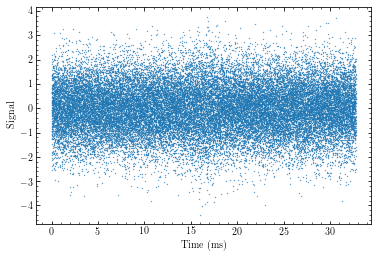

In [4]:
from os import system
system("wget http://www.pmaweb.caltech.edu/~physlab/arecibo/arecibo1.txt")
system("wget http://www.pmaweb.caltech.edu/~physlab/arecibo/arecibo2.txt")

y1 = np.loadtxt("arecibo1.txt")
t1 = np.arange(len(y1))*1e-3
plt.scatter(t1,y1,s=0.1)
plt.xlabel("Time (ms)")
plt.ylabel("Signal")
plt.show()

Now let's see what its fft looks like...

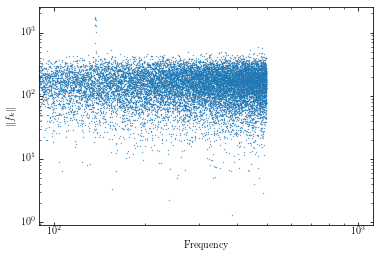

136.993408203125


In [5]:
freq = fftfreq(len(y1)) * 1e3 # multiply by the sampling rate to get freq in hz
fft1 = fft(y1)
plt.scatter(freq, np.abs(fft1),s=0.1)
plt.loglog()
plt.xlabel("Frequency")
plt.ylabel(r"$\|f_k\|$")
plt.show()
print(freq[np.abs(fft1).argmax()])

Looks like we have a spike at 137Hz, nifty! Let's zoom in on that blip.

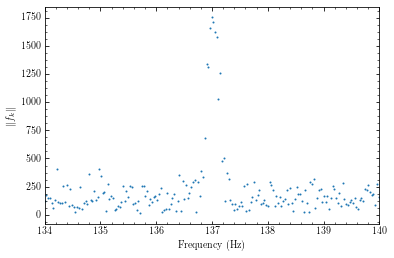

In [6]:
plt.scatter(freq, np.abs(fft1),s=1)
plt.xlabel("Frequency (Hz)")
plt.ylabel(r"$\|f_k\|$")
plt.xlim(134,140)
plt.show()

OK, so a FWHM of maybe half a Hz? Let's fit this to a Gaussian to figure it out for suresies

In [7]:
from scipy.optimize import curve_fit

fitting_function = lambda x, *params: params[2] * np.exp(-(x-params[1])**2/(2*params[0]**2)) + params[3]
params, pcov = curve_fit(fitting_function, freq[freq>0], np.abs(fft1[freq>0]),(0.1,137,1750.,0)) # note: only keeping the freq>0 copy; data contains two mirror images
print("sigma_freq = %g +/- %g"%(params[0], pcov[0,0]**0.5))

sigma_freq = 0.118241 +/- 0.00657246


Since the fourier transform of a Gaussian of width sigma_t has sigma_omega = 1/sigma_t, sigma_t = 1/sigma_omega = 1/(2 Pi sigma_f)

In [8]:
print("The time constant of the envelope is %g s"%(1/params[0]/(2*np.pi)))

The time constant of the envelope is 1.34603 s


# Optional part: dechirping

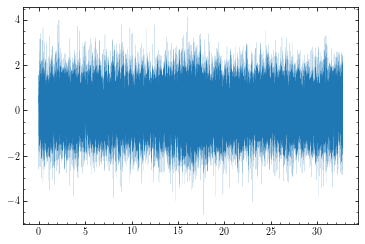

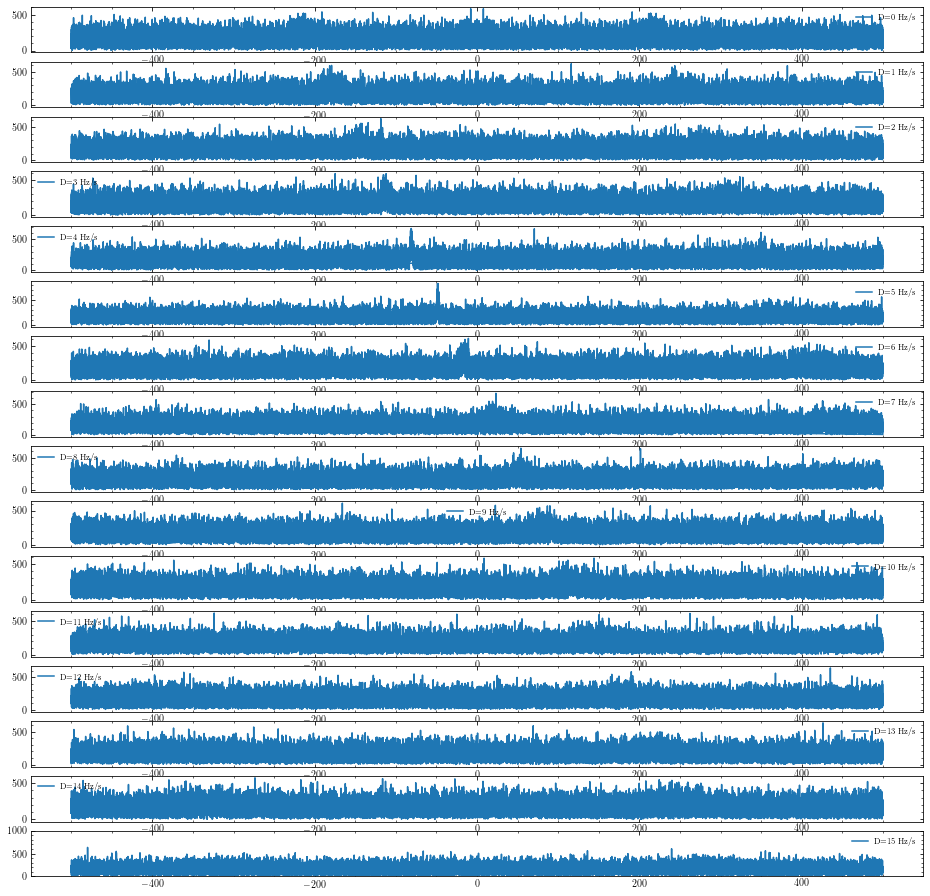

In [50]:
y2 = np.loadtxt("arecibo2.txt")
t2 = np.arange(len(y2))*1e-3 
plt.plot(t2, y2, lw=0.1)
plt.show()

# pick a set of chirp rates to sample
D = np.linspace(0, 15, 16)
plt.clf()
fig, axes = plt.subplots(16, figsize=(16,16))

#our strategy: plot the FFT for a range of D values, and see which gives the strongest peak
for i, a in enumerate(axes):
    dechirped = np.exp(1j * 2 * np.pi * D[i] * t2 * t2) * y2
    freq = fftfreq(len(y2)) * 1e3 # multiply by the sampling rate to get freq in hz
    fft_dechirped = fft(dechirped)
    a.plot(freq, np.abs(fft_dechirped), label='D=%g Hz/s'%D[i])
    #a.plot(t1[:10000], dechirped.real[:10000])
    #a.plot(t1[:1000])
    a.legend(loc=0, fontsize=8)
plt.ylim(0,1000)
plt.show()

Here we see a strong spike for a chirp rate of 5Hz/s

# Part 3

Now let's Lomb-Scargle that Gaussian signal we had...

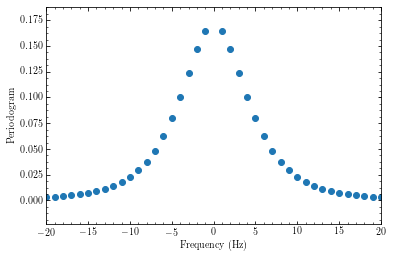

In [59]:
from scipy.signal import lombscargle
plt.clf()
gaussian_ls = lombscargle(t, f2, freqs[freqs!=0]*2*np.pi, precenter=True, normalize=True) # Note the 2pi to convert to angular frequency
plt.scatter(freqs[freqs!=0], gaussian_ls)
plt.xlim(-20, 20)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Periodogram")
plt.show()

Looks like the same width Gaussian we got before! And how about the Arecibo 1 data...

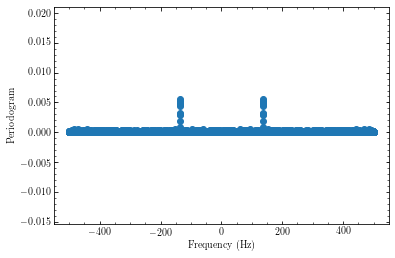

In [67]:
plt.clf()
arecibo1_ls = lombscargle(t1, y1, freq[freq!=0]*2*np.pi, normalize=True) # Note the 2pi to convert to angular frequency
plt.scatter(freq[freq!=0], arecibo1_ls)
#plt.xlim(-20, 20)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Periodogram")
plt.show()

Again, looks just like the FFT! Now for the Her-X1 data...

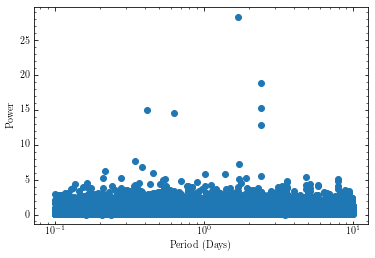

In [81]:
plt.clf()

MJD, mag = np.loadtxt("herx1.dat").T

sample_freqs = np.logspace(-1,1,10000) # 0.1 to 1 days
herx1_ls = lombscargle(MJD, mag - mag.mean(), sample_freqs * 2*np.pi) # Note the 2pi to convert to angular frequency
plt.scatter(1./sample_freqs, herx1_ls)
plt.xlabel("Period (Days)")
plt.ylabel("Power")
plt.xscale('log')
plt.show()

We see that spike at 1.7 days!